In [1]:
import os
import json
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
import matplotlib.pyplot as plt
from daisy_API import daisy_API
import daisy_hardware.motion_library as motion_library

from logger import Logger
from low_level_traj_gen import NN_tra_generator


class train_NNTG():
    def __init__(self,  
                num_primitive, 
                z_dim,
                policy_output_dim, 
                policy_hidden_num, 
                policy_lr, 
                batch_size,
                device):
            
        self.policy = NN_tra_generator(z_dim, policy_output_dim, policy_hidden_num, device)
        self.policy_lr = policy_lr
        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(),lr=self.policy_lr)
        self.batch_size = batch_size
        self.num_primitive = num_primitive
        self.z_dim = z_dim
        self.device = device
        self.learning_step = 0

        # define random z_action
        self.z_action_all = torch.tensor(np.random.normal(0,0.2,(num_primitive,z_dim)).tolist(),requires_grad=True, device = device)
        self.z_action_optimizer = torch.optim.Adam([self.z_action_all],lr=self.policy_lr, weight_decay=0.001)


    def sample_phase_action(self, primitive_index):
        idxs = np.random.randint(1,171, size=self.batch_size)
        phase = idxs / 170.0
        expert_action = np.empty((self.batch_size, 18), dtype=np.float32)
        
        for i in range(self.batch_size):
            expert_action[i] = traj[primitive_index][idxs[i]-1]

        return torch.as_tensor(np.reshape(phase,(self.batch_size,1)), device= self.device).float(), torch.as_tensor(expert_action, device= self.device).float()


    def update_model(self, num_iteration, save_dir):
        logger = Logger(save_dir, name = 'train')
        for _ in range(num_iteration):
            for i in range(self.num_primitive):
                # sample phase and expert action

                phase_vec, expert_action = self.sample_phase_action(i)
                z_vec = self.z_action_all[i] * torch.tensor(np.ones((self.batch_size,self.z_dim)).tolist(), requires_grad= True, device = self.device)

                pred_action = self.policy(z_vec, phase_vec)

                policy_loss = F.mse_loss(pred_action, expert_action) 
                self.policy_optimizer.zero_grad()
                policy_loss.backward()
                self.policy_optimizer.step()
                self.z_action_optimizer.step()

                self.learning_step += 1
                logger.log('train/model_loss', policy_loss)
                logger.dump(self.learning_step)
        
        self.save_model(save_dir)

    def save_model(self, save_dir):
        torch.save(self.policy.state_dict(),
                   '%s/NNTG.pt' % (save_dir) )
    
    def load_model(self, save_dir):
        self.policy.load_state_dict(
            torch.load('%s/NNTG.pt' % (save_dir)))

In [2]:
# form data to be signle file
traj = np.load('./save_data/trajectories_gaits.npz')
traj_1 = traj['traj_good'] # 15
traj_mapped = np.empty((15, 700, 18))
index = [11,2,7,13,4,8,9,14,5,12,10,6,3,1,0]
for i in range(15):
    traj_mapped[i] = traj_1[index[i]]

traj_2 = np.load('./save_data/raibert_expert_trajectory.npy') #10
traj_3 = np.load('./save_data/sinusoidal_expert_trajectory.npy') #5
traj_4 = np.load('./save_data/trial_2/footstep_exp_424.npy') #4
traj_5 = np.load('./save_data/trial_2/footstep_exp_33.npy') #6


traj_total = np.empty((25, 170, 18))
for i in range(10):
    traj_total[i+10] = traj_4[i]

for i in range(10):
    traj_total[i] = traj_5[i]

# for i in range(5):
#     traj_total[i+10] = traj_3[i]

# for i in range(2):
#     traj_total[i+10] = traj_mapped[i][100:270]

np.save('./save_data/expert_trajectory_total.npy', traj_total)

(25, 170, 18)


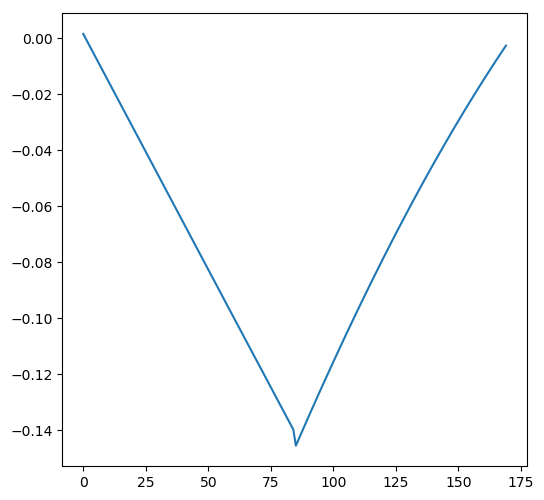

In [219]:
# load data and generate expert data   
traj = np.load('./save_data/expert_trajectory_total.npy')
print(np.shape(traj))
traj = np.swapaxes(traj,1,2)
axis = range(170)
plt.plot(axis, traj[19][0])
plt.show()


In [3]:
# train the nerual network
z_dim = 1
num_primitive = 20
policy_output_dim = 18
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
traj = np.load('./save_data/expert_trajectory_total.npy')
tra_learning = train_NNTG( num_primitive = num_primitive, 
            z_dim= z_dim,
            policy_output_dim = policy_output_dim, 
            policy_hidden_num = 512, 
            policy_lr = 1e-3, 
            batch_size = 12,
            device = device)

In [4]:
# # # train NNTG
print('Z_action before optimization', tra_learning.z_action_all)
tra_learning.update_model(num_iteration =500, save_dir = './save_data/trial_2')
print('Z_action after optimization', tra_learning.z_action_all)

Z_action before optimization tensor([[ 0.0550],
        [-0.1663],
        [-0.0629],
        [-0.0031],
        [-0.0448],
        [-0.1129],
        [-0.1906],
        [ 0.0266],
        [ 0.3858],
        [ 0.1322],
        [ 0.1376],
        [-0.1030],
        [-0.1414],
        [-0.1942],
        [ 0.3161],
        [-0.2812],
        [ 0.1524],
        [-0.2517],
        [-0.2886],
        [ 0.0848]], requires_grad=True)
Z_action after optimization tensor([[-0.2458],
        [-0.4042],
        [-0.4687],
        [-0.4426],
        [-0.0708],
        [-0.1538],
        [-0.5117],
        [-0.1635],
        [-0.2854],
        [-0.5785],
        [ 0.1052],
        [ 0.6234],
        [ 0.0316],
        [ 0.5404],
        [ 0.9267],
        [ 0.3865],
        [ 0.8823],
        [ 0.5545],
        [ 0.2272],
        [-0.7877]], requires_grad=True)


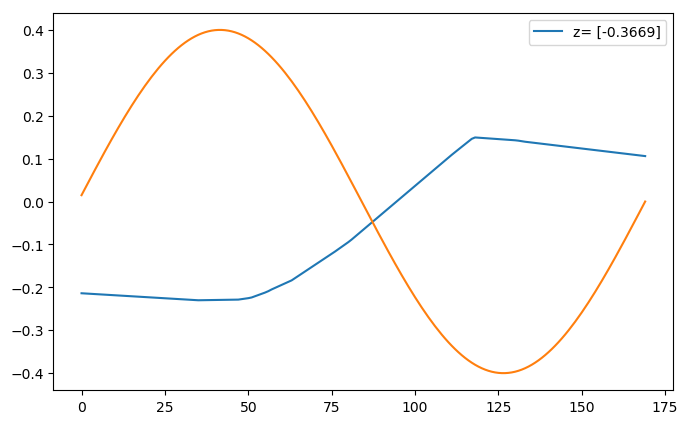

In [71]:
# # # test NNTG
test_num = 2
tra_learning.load_model(save_dir = './save_data/trial_2')
traj = np.load('./save_data/expert_trajectory_total.npy')
record_data = np.empty((test_num,170))
z_action = np.array([[-0.3669]])
axis = range(170)
aaa = np.swapaxes(traj,1,2)

for i in range(test_num):
    tra_learning.policy.z_action = z_action[i]
    for j in range(170):
        record_data[i][j] = tra_learning.policy.get_action(z_action[i], (j+1)/170.0)[0]

for i in range(test_num):
    plt.plot(axis, record_data[i], label = 'z= %s'%(str(z_action[i])))
    plt.plot(axis, aaa[0][0])
plt.legend()

plt.show()